# Goal: 
Find:   
- Reservation seasonality in general
- Reservation seasonality with location (zipcode)
- Reservation seasonality with pricing
- Which places are undervalued?

## Big assumption for seasonality analysis: 
- Nubmer of reviews/month has strong positive correlation with reservation frequency/month. 
- So below, I treat review frequency as reservation frequency. 

In [110]:
from sklearn.cross_validation import train_test_split
from gensim.models.word2vec import Word2Vec
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

# Reservation seasonality in general

### Read data and preprocess

In [118]:
df = pd.read_csv('data/df_new_en.csv').drop('Unnamed: 0', 1)
df = df[['id', 'listing_url','date', 'zipcode']]
df =  df.dropna()
print df.info()
df.head(1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132034 entries, 0 to 132331
Data columns (total 4 columns):
id             132034 non-null int64
listing_url    132034 non-null object
date           132034 non-null object
zipcode        132034 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 5.0+ MB
None


,id,listing_url,date,zipcode
0,1994427,https://www.airbnb.com/rooms/1994427,2014-02-27,94110


In [119]:
# dates to year-month
df.date = [month[:7] for month in df.date]
df.head()

,id,listing_url,date,zipcode
0,1994427,https://www.airbnb.com/rooms/1994427,2014-02,94110
1,1994427,https://www.airbnb.com/rooms/1994427,2015-10,94110
2,1994427,https://www.airbnb.com/rooms/1994427,2015-10,94110
3,1994427,https://www.airbnb.com/rooms/1994427,2015-10,94110
4,1994427,https://www.airbnb.com/rooms/1994427,2015-10,94110


### Convert to datetime

In [120]:
year_month_df = df[:][:]
import datetime
def convert_datetime(x):
    dt = datetime.datetime.strptime(x, "%Y-%m")
#     return dt.date()
    return 1000*dt.year + dt.month
year_month_df['date'] = year_month_df['date'].apply(convert_datetime)
year_month_df.head()

,id,listing_url,date,zipcode
0,1994427,https://www.airbnb.com/rooms/1994427,2014002,94110
1,1994427,https://www.airbnb.com/rooms/1994427,2015010,94110
2,1994427,https://www.airbnb.com/rooms/1994427,2015010,94110
3,1994427,https://www.airbnb.com/rooms/1994427,2015010,94110
4,1994427,https://www.airbnb.com/rooms/1994427,2015010,94110


### Let's see seasonality based on review frequency 

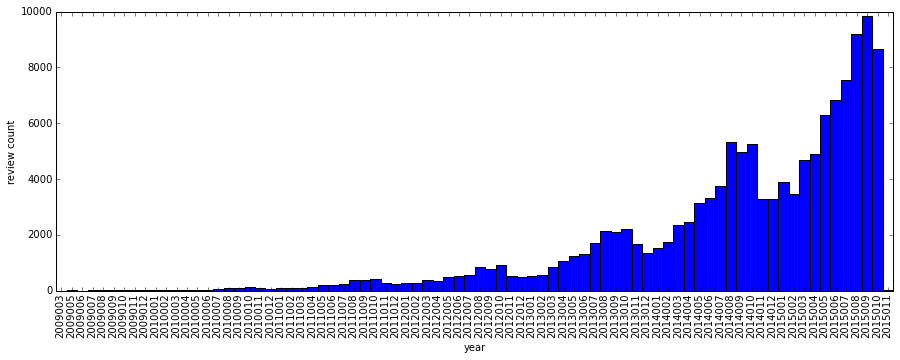

In [121]:
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

labels, values = zip(*sorted(Counter(year_month_df.date).items()))

indexes = np.arange(len(labels))
width = 1
plt.figure(figsize=(15,5))
plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels,  rotation='vertical')
plt.ylabel('review count')
plt.xlabel('year')
plt.show()

Two findings:  
- REALLY quick growth 
- Possible seasonality (increase the counts during summer time)

### Number of visiters at least overnight visitors in SF (in millions)

- Let's see if continous increase of counts in airbnb data is due to number of SF visitors

#### Domestic
<img src="data/sfvisiter_dom.png" alt="" style="width: 700px;"/>
#### International
<img src="data/sfvisitor_int.png" alt="" style="width: 700px;"/>  
Source: statista.com

- The growth rate of the number of SF visitors is not comparable to airbnb's growth  -> hotels should be scared by the service :D
- It'll be interesting to further research on which visitor groups (younger students, business people etc) contribute to the growth

## Let's see monthly (ignore year)

In [78]:
import datetime
def convert_datetime_to_month(x):
    dt = datetime.datetime.strptime(x, "%Y-%m")
    return dt.month
df['date'] = df['date'].apply(convert_datetime_to_month)
df.head()

,id,listing_url,date,zipcode
0,1994427,https://www.airbnb.com/rooms/1994427,2,94110
1,1994427,https://www.airbnb.com/rooms/1994427,10,94110
2,1994427,https://www.airbnb.com/rooms/1994427,10,94110
3,1994427,https://www.airbnb.com/rooms/1994427,10,94110
4,1994427,https://www.airbnb.com/rooms/1994427,10,94110


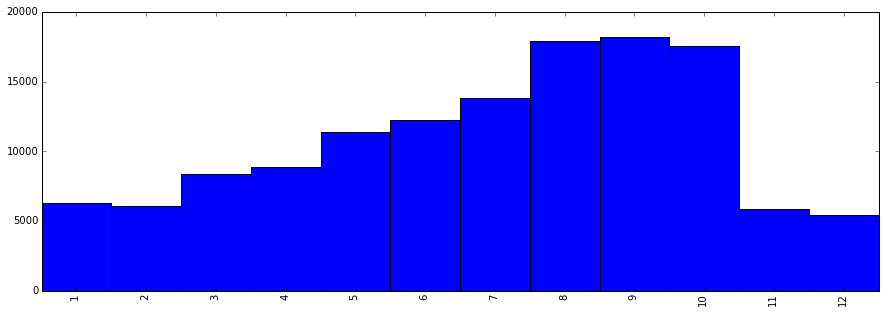

In [79]:
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

labels, values = zip(*sorted(Counter(df.date).items()))

indexes = np.arange(len(labels))
width = 1
plt.figure(figsize=(15,5))
plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels,  rotation='vertical')
plt.show()

- It seems that seasonality is present. Let's find that out with chi-square test.

## Hypothesis

Null: number of reviews is equal across months

Alternative: number of reviews is different across months

In [90]:
obs_val = Counter(df.date).values()
null_val = [np.mean(obs_val)]*12
print obs_val
print null_val

[6270, 6106, 8377, 8891, 11419, 12218, 13857, 17914, 18167, 17534, 5868, 5413]
[11002.833333333334, 11002.833333333334, 11002.833333333334, 11002.833333333334, 11002.833333333334, 11002.833333333334, 11002.833333333334, 11002.833333333334, 11002.833333333334, 11002.833333333334, 11002.833333333334, 11002.833333333334]


In [107]:
import scipy.stats as ss
ss.chisquare(obs_val,null_val)

Power_divergenceResult(statistic=24256.299225956947, pvalue=0.0)

- Since p-value = 0.00, we can reject the null. So, we have enough evidence to conclude that seasonality is present.

# Reservation seasonality with location (zipcode)

In [111]:
df = pd.read_csv('data/df_new.csv').drop('Unnamed: 0', 1)
df = df[['id', 'listing_url','date', 'zipcode']]
df =  df.dropna()
print df.info()
df.head(1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142919 entries, 0 to 143236
Data columns (total 4 columns):
id             142919 non-null int64
listing_url    142919 non-null object
date           142919 non-null object
zipcode        142919 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 5.5+ MB
None


,id,listing_url,date,zipcode
0,1994427,https://www.airbnb.com/rooms/1994427,2014-02-27,94110


## Convert to datetime

In [112]:
import datetime
def convert_datetime(x):
    dt = datetime.datetime.strptime(x, "%Y-%m-%d")
    return dt.date()
df['date'] = df['date'].apply(convert_datetime)
df.head()

,id,listing_url,date,zipcode
0,1994427,https://www.airbnb.com/rooms/1994427,2014-02-27,94110
1,1994427,https://www.airbnb.com/rooms/1994427,2015-10-07,94110
2,1994427,https://www.airbnb.com/rooms/1994427,2015-10-12,94110
3,1994427,https://www.airbnb.com/rooms/1994427,2015-10-17,94110
4,1994427,https://www.airbnb.com/rooms/1994427,2015-10-26,94110


## Let's see if there is seasonality with season

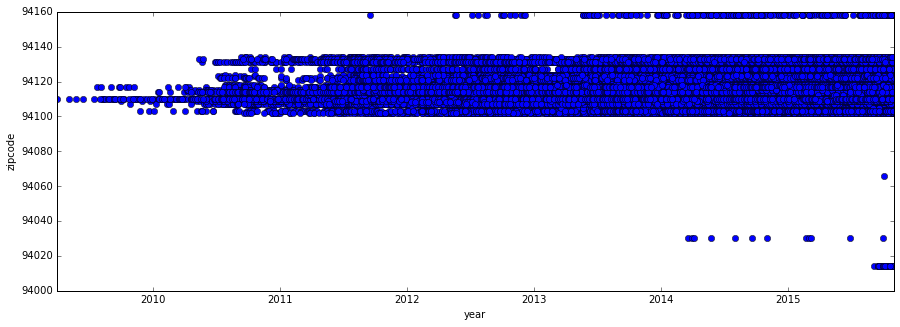

In [113]:
import pylab
%matplotlib inline
plt.figure(figsize=(15,5))
pylab.plot_date(df.date, df.zipcode)
plt.xlabel('year')
plt.ylabel('zipcode')

- Only cirtain areas are popular. Probably city or near city areas.
- Can't really tell.. Let's dig deeper

In [75]:
df.date[0]

datetime.date(2014, 2, 27)

### Focus on zipcode from 94100 to 94140

In [114]:
df.zipcode = df['zipcode'].apply(lambda x:int(x))

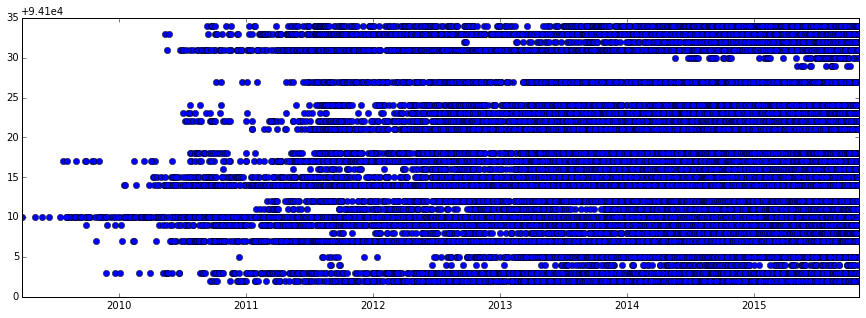

In [116]:
df2 = df[df['zipcode'] > 94100]
df2 = df2[df2['zipcode'] < 94140]

plt.figure(figsize=(15,5))
pylab.plot_date(df2.date, df2.zipcode)

- Can't really tell anything..

### What about per year?

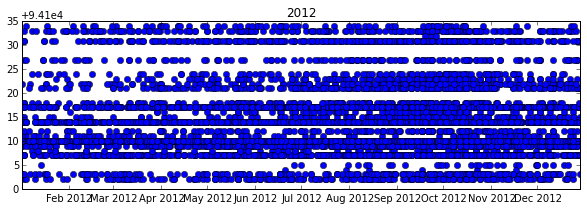

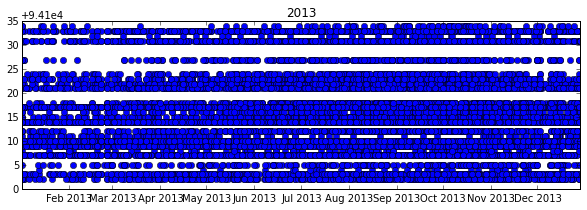

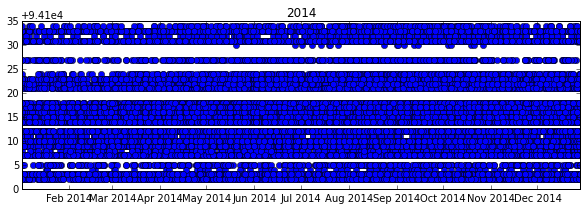

In [117]:
df2012 = df2[df2['date'] >datetime.date(2012, 1, 1)]
df2012 = df2012[df2012['date'] < datetime.date(2012, 12, 30)]
df2013 = df2[df2['date'] >datetime.date(2013, 1, 1)]
df2013 = df2013[df2013['date'] < datetime.date(2013, 12, 30)]
df2014 = df2[df2['date'] >datetime.date(2014, 1, 1)]
df2014 = df2014[df2014['date'] < datetime.date(2014, 12, 30)]
import pylab
%matplotlib inline
plt.figure(figsize=(10,3))
pylab.plot_date(df2012.date, df2012.zipcode)
plt.title('2012')
plt.show()
plt.figure(figsize=(10,3))
pylab.plot_date(df2013.date, df2013.zipcode)
plt.title('2013')
plt.show()
plt.figure(figsize=(10,3))
pylab.plot_date(df2014.date, df2014.zipcode)
plt.title('2014')
plt.show()

- We can't visually find a pattern. I'll stop here for this.

# Reservation seasonality with pricing
- Are Airbnb places price responsive/sensitive on demand?

### Read data and preprocess

In [122]:
from collections import Counter
df = pd.read_csv('data/df_new_en.csv').drop('Unnamed: 0', 1)
price_season = df[['date','price']]
price_season.head()

,date,price
0,2014-02-27,$170.00
1,2015-10-07,$170.00
2,2015-10-12,$170.00
3,2015-10-17,$170.00
4,2015-10-26,$170.00


In [124]:
from re import sub
from decimal import Decimal

def doller_to_int(x):
    x = str(x)
    x = Decimal(sub(r'[^\d.]', '', x))
    x = float(x)
    return x

# doller_to_int(df.price[0])
price_season.price = price_season['price'].apply(doller_to_int)

price_count  = Counter(price_season.price)

### Review frequency based on price

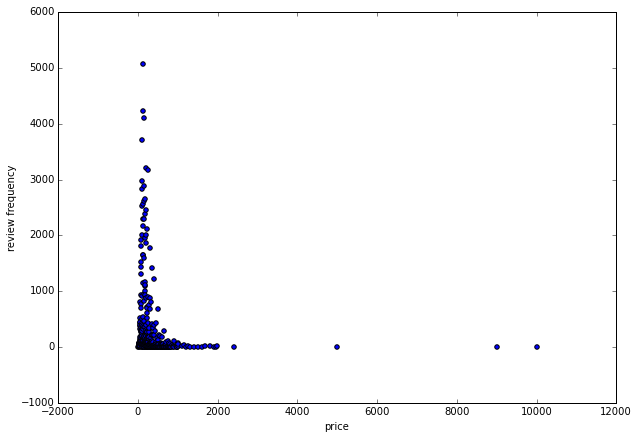

In [126]:
plt.figure(figsize=(10,7))
plt.scatter(price_count.keys(), price_count.values())
plt.xlabel('price')
plt.ylabel('review frequency')

- Most places are between 0 and 2,000 dollar range

### Get rid of price points above 2500 since they could affect the averag price too much

(preferablly I should've run tests on influencial points as well as leverage points if I had more time)

In [127]:
price_season2 = price_season[price_season['price'] < 2500]
len(price_season), len(price_season2)

(132332, 132325)

## Get rid of days (only year and month)

In [128]:
# dates to year-month
price_season2.date = [month[:7] for month in price_season2.date]

# convert to datetime 
import datetime
def convert_datetime(x):
    dt = datetime.datetime.strptime(x, "%Y-%m")
    return dt.date()
price_season2['date'] = price_season2['date'].apply(convert_datetime)
price_season2.head()

/Users/kimitakanakazawa/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,date,price
0,2014-02-01,170
1,2015-10-01,170
2,2015-10-01,170
3,2015-10-01,170
4,2015-10-01,170


## Group by listing id and make average price for each month

In [129]:
groupby_month = price_season2.groupby('date').aggregate(np.mean)
groupby_month.head()

,price
date,
2009-03-01,181.0
2009-05-01,250.0
2009-06-01,250.0
2009-07-01,210.0
2009-08-01,197.9


## Let's see if there is pricing pattern 

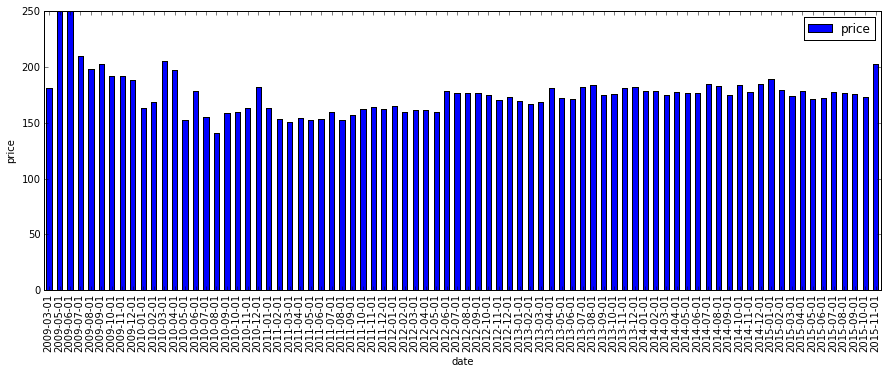

In [130]:
groupby_month.plot(kind='bar',figsize=(15,5))
plt.ylabel('price')

### Possible decrease in price from June to March (possibly August) between 2009-2010. Possible reasons:  
- SF visitor counts directly affected host's pricing strategy.
- Early adopter hosts would have had higher prices (due to un-educated pricing or monopoly-like situation) and as growing number of hosts being added (so more competitive and hosts get smarter), the price would have been optimized to the right market level.

### But can't really say anything for seasonality..

### What about monthly?

In [131]:
price_season3 = price_season2[:][:]
import datetime
def convert_datetime_to_month(x):
    return x.month
price_season3['date'] = price_season3['date'].apply(convert_datetime_to_month)
price_season3.head()


,date,price
0,2,170
1,10,170
2,10,170
3,10,170
4,10,170


In [132]:
groupby_month2 = price_season3.groupby('date').aggregate(np.mean)
groupby_month2

,price
date,
1,183.627507
2,176.760987
3,173.045980
4,177.832417
5,171.902930
6,173.119794
7,179.676557
8,178.754106
9,175.042630


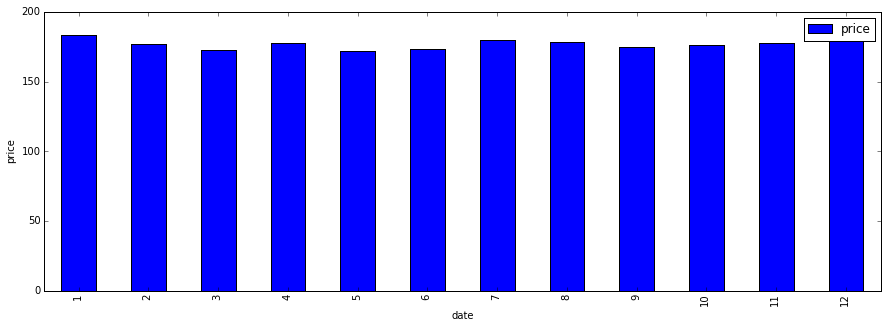

In [133]:
groupby_month2.plot(kind='bar',figsize=(15,5))
plt.ylabel('price')

- Looks like no relationship or price is pretty much fixed at macro level (seasonality ignorant) but let's check if that's right.

## Hypothesis

Null: pricing is equal across months

Alternative: pricing is different across months

In [106]:
obs_monthly_price = list(groupby_month2.price)
null_monthly_price = [np.mean(obs_monthly_price)]*12
print obs_monthly_price
print null_monthly_price

[183.62750716332377, 176.76098676686817, 173.04597974985111, 177.83241665731282, 171.90292960209882, 173.11979421852033, 179.67655743608211, 178.75410566163782, 175.04263033565897, 176.61146822913705, 177.64591836734695, 182.13635526073338]
[177.17972078738092, 177.17972078738092, 177.17972078738092, 177.17972078738092, 177.17972078738092, 177.17972078738092, 177.17972078738092, 177.17972078738092, 177.17972078738092, 177.17972078738092, 177.17972078738092, 177.17972078738092]


In [108]:
import scipy.stats as ss
ss.chisquare(obs_monthly_price,null_monthly_price)

Power_divergenceResult(statistic=0.80132847911568961, pvalue=0.99998380219808847)

-No seasonality.

# Find undervalued places with sentiment, price, review count

- Lastly, just because I was moving to San Francsico and for my benefit, I wanted to search undere-valued places on airbnb.

## Read data and preprocess

In [64]:
df = pd.read_csv('data/df_new_en.csv').drop('Unnamed: 0', 1)
df = df[['review_id','id','listing_url','price','zipcode']]
df.head()
# print df.info()


,review_id,id,listing_url,price,zipcode
0,10612780,1994427,https://www.airbnb.com/rooms/1994427,$170.00,94110
1,49925683,1994427,https://www.airbnb.com/rooms/1994427,$170.00,94110
2,50537634,1994427,https://www.airbnb.com/rooms/1994427,$170.00,94110
3,51077613,1994427,https://www.airbnb.com/rooms/1994427,$170.00,94110
4,52109034,1994427,https://www.airbnb.com/rooms/1994427,$170.00,94110


In [68]:
sentiment_df = pd.read_csv('data/df_new_en_labeled_bagging_sgd_sentiment.csv').drop('Unnamed: 0', 1)
sentiment_df.head()

,review_id,bagging_sgd_sentiment
0,10612780,1
1,49925683,1
2,50537634,1
3,51077613,1
4,52109034,1


In [310]:
Counter(sentiment_df.bagging_sgd_sentiment)

Counter({-1.0: 1649, 1.0: 130683})

In [311]:
len(df),len(sentiment_df)

(132332, 132332)

In [312]:
df2 = pd.merge(df,sentiment_df,on='review_id')
df2.head()

,review_id,id,listing_url,price,zipcode,bagging_sgd_sentiment
0,10612780,1994427,https://www.airbnb.com/rooms/1994427,$170.00,94110,1
1,49925683,1994427,https://www.airbnb.com/rooms/1994427,$170.00,94110,1
2,50537634,1994427,https://www.airbnb.com/rooms/1994427,$170.00,94110,1
3,51077613,1994427,https://www.airbnb.com/rooms/1994427,$170.00,94110,1
4,52109034,1994427,https://www.airbnb.com/rooms/1994427,$170.00,94110,1


In [313]:
len(df2)

132332

In [314]:
def doller_to_int(x):
    x = str(x)
    x = Decimal(sub(r'[^\d.]', '', x))
    x = float(x)
    return x

# doller_to_int(df.price[0])
df2.price = df2['price'].apply(doller_to_int)
df2.head()

,review_id,id,listing_url,price,zipcode,bagging_sgd_sentiment
0,10612780,1994427,https://www.airbnb.com/rooms/1994427,170,94110,1
1,49925683,1994427,https://www.airbnb.com/rooms/1994427,170,94110,1
2,50537634,1994427,https://www.airbnb.com/rooms/1994427,170,94110,1
3,51077613,1994427,https://www.airbnb.com/rooms/1994427,170,94110,1
4,52109034,1994427,https://www.airbnb.com/rooms/1994427,170,94110,1


In [315]:
Counter(df2.bagging_sgd_sentiment)

Counter({-1.0: 1649, 1.0: 130683})

In [316]:
df2['bagging_sgd_sentiment'][df2['bagging_sgd_sentiment'] == -1] = 0
Counter(df2.bagging_sgd_sentiment)

/Users/kimitakanakazawa/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Counter({0.0: 1649, 1.0: 130683})

In [318]:
df2['review_count'] = 1
df2.head()

,review_id,id,listing_url,price,zipcode,bagging_sgd_sentiment,review_count
0,10612780,1994427,https://www.airbnb.com/rooms/1994427,170,94110,1,1
1,49925683,1994427,https://www.airbnb.com/rooms/1994427,170,94110,1,1
2,50537634,1994427,https://www.airbnb.com/rooms/1994427,170,94110,1,1
3,51077613,1994427,https://www.airbnb.com/rooms/1994427,170,94110,1,1
4,52109034,1994427,https://www.airbnb.com/rooms/1994427,170,94110,1,1


### Group by id to see count of total positive sentiment and total review count.

In [320]:
review_by_listing = df2[['id','bagging_sgd_sentiment','review_count']].groupby('id').aggregate(sum)
print len(review_by_listing)
review_by_listing.head()

5667


,bagging_sgd_sentiment,review_count
id,,
958,34,34
2822,41,41
5193,180,184
5841,35,35
5858,104,104


### Give sentiment rate (positive sentiment review count /total review count)
- How likely the place has positive sentiment

In [321]:
review_by_listing['sentiment_rate'] = review_by_listing['bagging_sgd_sentiment']/(review_by_listing['review_count'])
review_by_listing.head()

,bagging_sgd_sentiment,review_count,sentiment_rate
id,,,
958,34,34,1.000000
2822,41,41,1.000000
5193,180,184,0.978261
5841,35,35,1.000000
5858,104,104,1.000000


### Sentiment rate distribution looks like this (< 0.9)

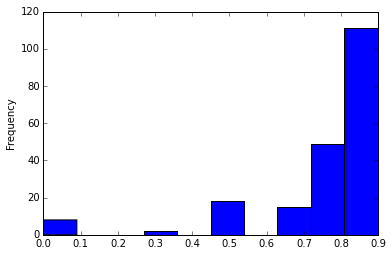

In [322]:
review_by_listing[review_by_listing.sentiment_rate < 0.9]['sentiment_rate'].plot(kind='hist')

### Limit only sentiment_rate = 1 (places with only good reviews)

In [330]:
review_by_listing_all_positive = review_by_listing[review_by_listing.sentiment_rate == 1]
# Counter(review_by_listing_all_positive.sentiment_rate)

### Limit only review_count > 10 

In [331]:
review_by_listing_all_positive = review_by_listing_all_positive[review_by_listing_all_positive.review_count >10]
# Counter(review_by_listing_all_positive.sentiment_rate)
len(review_by_listing_all_positive)

1844

- There are 1844 potentially undervalued places.

### Id (airbnb place) with average price

In [332]:
price_by_listing = df2[['id','price']].groupby('id').aggregate(np.mean)
price_by_listing.head()

,price
id,
958,170
2822,138
5193,160
5841,181
5858,250


### Id with zipcode

In [333]:
zipcode_df = df2[['id','zipcode']].groupby('id').first()
print len(zipcode_df)
zipcode_df.head()

5667


,zipcode
id,
958,94117
2822,94124
5193,94109
5841,94110
5858,94110


### Merge the grouped-by dataframes

In [334]:
undervalued_listing_df = pd.merge(review_by_listing_all_positive.reset_index(), price_by_listing.reset_index(), how='inner', on=['id'])
undervalued_listing_df = pd.merge(undervalued_listing_df, zipcode_df.reset_index(), how='inner',on=['id'])

print len(undervalued_listing_df)
undervalued_listing_df.head()

1844


,id,bagging_sgd_sentiment,review_count,sentiment_rate,price,zipcode
0,958,34,34,1,170,94117
1,2822,41,41,1,138,94124
2,5841,35,35,1,181,94110
3,5858,104,104,1,250,94110
4,8339,18,18,1,395,94117


# Top undervalued rooms (Ranked by price and nubmer of reviews)

### Popular undervalued places. Great for short stay

In [338]:
undervalued_listing_df.sort(columns=['review_count', 'price'], ascending=[False, True])[:20]

/Users/kimitakanakazawa/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,id,bagging_sgd_sentiment,review_count,sentiment_rate,price,zipcode
22,25463,200,200,1,115,94117
419,918341,196,196,1,190,94107
17,23630,192,192,1,165,94114
68,87640,190,190,1,125,94131
218,465723,188,188,1,150,94116
266,567239,187,187,1,89,94131
847,1995487,186,186,1,199,94110
455,992676,183,183,1,120,94131
167,311259,181,181,1,120,94134
328,727866,178,178,1,119,94116


### Hidden undervalued places (funkier). Great for students and longer stayer

In [337]:
undervalued_listing_df.sort(columns=['price','review_count'], ascending=[True,False])[:20]

/Users/kimitakanakazawa/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,id,bagging_sgd_sentiment,review_count,sentiment_rate,price,zipcode
96,152517,16,16,1,22,94112
651,1446043,18,18,1,27,94122
564,1218290,16,16,1,27,94122
563,1218239,18,18,1,30,94122
1769,7262134,16,16,1,32,94122
428,939833,26,26,1,40,94117
1794,7462925,21,21,1,40,94121
1795,7462926,19,19,1,40,94121
1796,7462930,18,18,1,40,94121
1797,7462935,18,18,1,40,94121
